In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os, sys, torch
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import data, hdc, helper, nn, sim
from cfgs.fedargs import *

In [23]:
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [24]:
train_data, test_data = data.load_dataset(fedargs.dataset, only_to_tensor = True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True, **kwargs)

In [25]:
fedargs.model = hdc.HDC(fedargs.one_d_len, fedargs.hdc_proj_len, len(fedargs.labels), device)

In [26]:
# Train    
train_acc = fedargs.model.train(train_loader, device)
#fedargs.model.load_state_dict(torch.load('hdc.pth'))

In [27]:
# Test, Plot and Log
test_acc = fedargs.model.test(test_loader, device)

In [28]:
hdc_train_vectors = fedargs.model.train_vectors

In [29]:
#print(train_acc, test_acc)
print(test_acc)

82.2300033569336


In [30]:
hdc_train_vectors

tensor([[413594.1562, 390797.1562, 409961.3750,  ..., 410616.0625,
         398484.3125, 400035.5938],
        [208951.5781, 212726.1250, 185367.2812,  ..., 195493.6719,
         198841.2188, 190918.4062],
        [353545.4375, 347936.0312, 339464.1250,  ..., 347765.1250,
         338524.1562, 342029.1875],
        ...,
        [298596.1562, 282200.2188, 282753.6250,  ..., 279368.7812,
         270344.1562, 271063.1562],
        [357189.7812, 349922.8125, 332973.8438,  ..., 349237.8438,
         333702.3438, 332882.6562],
        [298082.3438, 286517.2812, 282852.2500,  ..., 284992.3125,
         267025.3438, 279061.9062]])

In [31]:
model = nn.ModelMNIST()

In [32]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024, shuffle=True, **kwargs)

In [33]:
'''
# Train
from tqdm import tqdm

fedargs.epochs = 5
fedargs.local_rounds = 1
for epoch in tqdm(range(fedargs.epochs)):
    _, model, loss = fedargs.train_func(model, train_loader, 
                                        fedargs.learning_rate,
                                        fedargs.weight_decay,
                                        fedargs.local_rounds, device)
torch.save(model.state_dict(), 'nn.pth')                                        
'''
model.load_state_dict(torch.load('nn.pth'))
model.eval()

ModelMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [34]:
test_output = fedargs.eval_func(model, test_loader, device)
print(test_output)

{'test_loss': 0.07843767547607422, 'correct': 9745, 'accuracy': 97.45}


In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f

def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze() 
    print('Predict class confidence:',ps)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
def predict(model, img, view = True):
    with torch.no_grad():
        logits = model.forward(img)

    ps = f.softmax(logits, dim=1)
    if view:
        view_classify(img.view(1, 28, 28), ps)
    
    _, label = torch.max(ps, 1)
    return label 

Predict class confidence: [5.8128040e-09 1.8354457e-11 2.1705540e-09 6.3893281e-06 1.1949920e-11
 9.9994349e-01 7.5384393e-10 5.4906555e-11 4.6604862e-05 3.4682198e-06]


tensor([5])

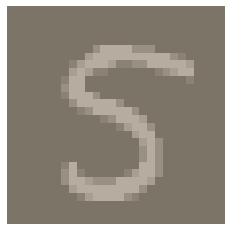

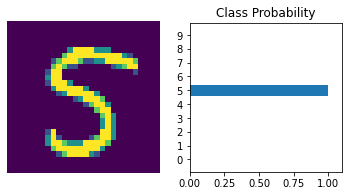

In [36]:
image, label = next(iter(test_loader))
lbl = label[0]
helper.imshow(image[0])
img = image[0].unsqueeze(0)
predict(model, img)

In [37]:
img_enc = img.reshape(1, 784) @ fedargs.model.proj
img_enc.size()

torch.Size([1, 10000])

Predict class confidence: [5.8145897e-09 1.8362895e-11 2.1709183e-09 6.3892485e-06 1.1954457e-11
 9.9994349e-01 7.5415307e-10 5.4927920e-11 4.6600064e-05 3.4696391e-06]


tensor([5])

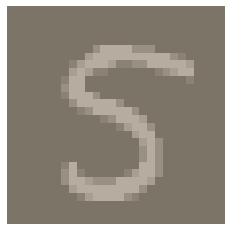

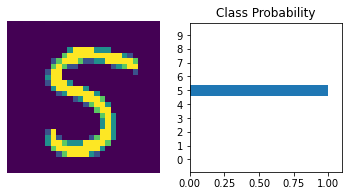

In [38]:
dec_img = img_enc @ fedargs.model.proj_inv
dec_img = dec_img.view(1, 28, 28)
helper.imshow(dec_img)
dec_img = dec_img.unsqueeze(0)
predict(model, dec_img)

In [39]:
from libs import sim
print(sim.cosine_similarity(img.reshape(784), dec_img.reshape(784)))

0.9999998


In [75]:
import copy
b_arr = fedargs.model.train_vectors[8]
c_arr = img_enc.reshape(10000)
p_arr = copy.deepcopy(c_arr)

dot_mb = 1 * sim.dot(b_arr, c_arr)
norm_b = sim.norm(b_arr)
norm_c = sim.norm(c_arr)
norm_m = norm_c
sim_mg = 1

kwargs = {"scale_norm": 10}

def get_img(p_arr):
    p_arr = p_arr.reshape(1, 10000)         
    p_img = p_arr @ fedargs.model.proj_inv
    p_img = p_img.view(1, 28, 28)
    p_img = p_img.unsqueeze(0)
    return p_img

count_m = 0
count_t = 0
c_images = []
for index in range(3000):
    p_arr, dot_mb, norm_m, sim_mg, updated = sim.cosine_coord_vector_adapter(b_arr, p_arr, index, dot_mb, norm_m, sim_mg, c_arr, norm_c, norm_b, **kwargs)
    p_img = get_img(p_arr)
    _lbl = predict(model, p_img, False)
    if lbl != _lbl:
        c_images.append(p_img)
        count_m = count_m + 1
        if _lbl == 8:
            count_t = count_t + 1
            
print(count_m, count_t)

3000 86


Predict class confidence: [4.9768109e-04 4.7949675e-04 1.4060343e-03 1.7463658e-02 2.5849597e-04
 3.8169676e-01 3.0928804e-04 6.1051003e-05 5.8577228e-01 1.2055344e-02]


tensor([8])

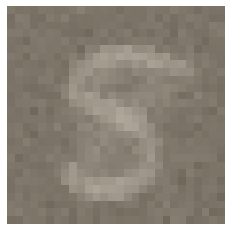

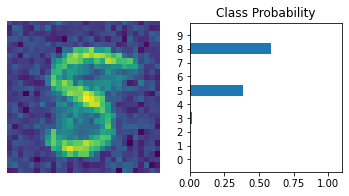

In [76]:
helper.imshow(p_img.squeeze(0))
predict(model, p_img)

Predict class confidence: [5.1707478e-04 5.7604013e-04 1.7081526e-03 1.7874550e-02 3.1475240e-04
 3.0406830e-01 3.4541680e-04 7.5763361e-05 6.6302294e-01 1.1496996e-02]


tensor([8])

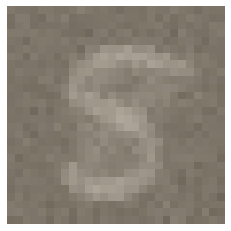

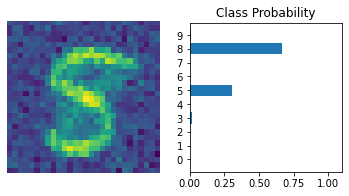

In [42]:
helper.imshow(c_images[155].squeeze(0))
predict(model, c_images[155])

In [43]:
test_data = data.random_split(train_data, 0.001)[1]

In [44]:
mal_hdc_data = poison.hdc_dp(hdc_dp_attack["args"], {4:6}, 1, (test_data, fedargs.model.train_vectors, fedargs.model.proj, fedargs.model.proj_inv))

In [45]:
len(mal_hdc_data)

60

Predict class confidence: [1.3654758e-01 7.0179149e-04 1.1831286e-02 8.2754239e-04 7.0475936e-03
 5.2057814e-02 7.4760598e-01 2.8243090e-03 3.7929069e-02 2.6269341e-03]


tensor([6])

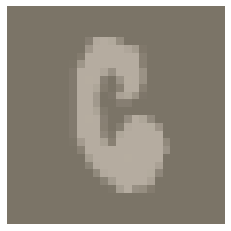

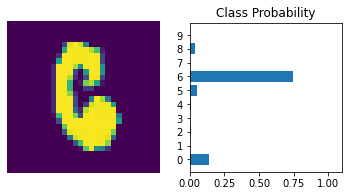

In [46]:
mal_hdc_data_loader = torch.utils.data.DataLoader(mal_hdc_data, batch_size=len(mal_hdc_data), shuffle=True)
lbl = 5
while lbl != 6:
    image, label = next(iter(mal_hdc_data_loader))
    lbl = label[0]
    
#print(image.size())

helper.imshow(image[0])
img = image[0].unsqueeze(0)
predict(model, img)